In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8532111320384126791, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10968950375
 locality {
   bus_id: 2
 }
 incarnation: 1907271828630325544
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:83:00.0, compute capability: 6.1", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 10968950375
 locality {
   bus_id: 2
 }
 incarnation: 12684478641379971964
 physical_device_desc: "device: 1, name: GeForce GTX 1080 Ti, pci bus id: 0000:84:00.0, compute capability: 6.1", name: "/device:GPU:2"
 device_type: "GPU"
 memory_limit: 10968950375
 locality {
   bus_id: 2
 }
 incarnation: 14854036007099512097
 physical_device_desc: "device: 2, name: GeForce GTX 1080 Ti, pci bus id: 0000:87:00.0, compute capability: 6.1", name: "/device:GPU:3"
 device_type: "GPU"
 memory_limit: 10968950375
 locality {
   bus_id: 2
 }
 incarnation: 12369844984683239959
 physical_dev

In [3]:
import keras
import tensorflow as tf
from keras import backend as K

print("Keras Version:", keras.__version__)
print("Tensorflow Version:", tf.__version__)
print("image dim ordering:", K.image_dim_ordering())

Keras Version: 2.2.4
Tensorflow Version: 1.4.0
image dim ordering: tf


Using TensorFlow backend.


In [4]:
import os
import numpy as np
np.random.seed(777)

import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.models import load_model
from keras.applications.inception_v3 import InceptionV3

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
output_classes = 2
batch_size = 32 
img_height, img_width = 192, 192
epochs = 50

# nb_train_samples = 632384
nb_train_samples = 632300
nb_validation_samples = 184732
nb_test_samples = 15744

In [6]:
train_dir = 'data/train/'
validation_dir = 'data/validation'
test_dir = 'data/test'

In [7]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [8]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(validation_dir):
    print (root, len(files))
    
print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/train/ 0
data/train/normal 375900
data/train/cancer 256400
******************************
data/validation 0
data/validation/normal 110140
data/validation/cancer 74592
******************************
data/test 0
data/test/normal 9376
data/test/cancer 6368


In [9]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 632300 images belonging to 2 classes.
Found 184732 images belonging to 2 classes.
Found 15744 images belonging to 2 classes.


In [12]:
model = keras.models.Sequential()

# layer 1 - "filters the 224 x 224 x 3 input image with 96 kernels
#           of size 11 x 11 x 3 with a stride of 4 pixels"
model.add(keras.layers.Conv2D(filters=96,
                              kernel_size=(11, 11),
                              strides=4,
                              input_shape=(img_height, img_width, 3),
                              activation="relu",
                              padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(pool_size=(3, 3),
                                 strides=(2, 2)))

# layer 2 - "256 kernels of size 5 x 5 x 48"
model.add(keras.layers.Conv2D(filters=256,
                              kernel_size=(5, 5),
                              activation="relu",
                              padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(pool_size=(3, 3),
                                 strides=(2, 2)))

# layer 3 - "384 kernels of size 3 x 3 x 256"
model.add(keras.layers.Conv2D(filters=384,
                              kernel_size=(3, 3),
                              activation="relu",
                              padding="same"))
# layer 4 - "384 kernels of size 3 x 3 x 192"
model.add(keras.layers.Conv2D(filters=384,
                              kernel_size=(3, 3),
                              activation="relu",
                              padding="same"))
# layer 5 - "256 kernels of size 3 x 3 x 192"
model.add(keras.layers.Conv2D(filters=256,
                              kernel_size=(3, 3),
                              activation="relu",
                              padding="same"))
model.add(keras.layers.MaxPool2D(pool_size=(3, 3),
                                 strides=(2, 2)))

# flatten before feeding into FC layers
model.add(keras.layers.Flatten())


model.add(keras.layers.Dense(units=4096))  # layer 6
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(units=4096))  # layer 7
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(units=output_classes))  # layer 8

# output layer is softmax
model.add(Activation(tf.nn.softmax))

In [13]:
adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)
# sgd_opt = SGD(lr=1e-06, momentum=0.0, decay=0.0, nesterov=False)
# rmsp_opt = RMSprop(lr=1e-4, decay=0.9)
# sgd_opt = SGD(lr = 0.02, decay=75e-6, momentum=0.9, nesterov=True)

model.compile(optimizer = adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
history = model.fit_generator(
  train_generator,
  steps_per_epoch = nb_train_samples // batch_size,
  epochs = epochs,
  validation_data = validation_generator,
  validation_steps = nb_validation_samples // batch_size)

Epoch 1/50
19759/19759 [==============================] - 1210s 61ms/step - loss: 0.3392 - acc: 0.8552 - val_loss: 0.3987 - val_acc: 0.8546
Epoch 2/50
19759/19759 [==============================] - 1218s 62ms/step - loss: 0.2380 - acc: 0.9041 - val_loss: 0.2259 - val_acc: 0.9073
Epoch 3/50
19759/19759 [==============================] - 1162s 59ms/step - loss: 0.1944 - acc: 0.9240 - val_loss: 0.3131 - val_acc: 0.8926
Epoch 4/50
19759/19759 [==============================] - 1194s 60ms/step - loss: 0.1662 - acc: 0.9359 - val_loss: 0.1969 - val_acc: 0.9257
Epoch 5/50
19759/19759 [==============================] - 1193s 60ms/step - loss: 0.1450 - acc: 0.9448 - val_loss: 0.2512 - val_acc: 0.9059
Epoch 6/50
19759/19759 [==============================] - 1173s 59ms/step - loss: 0.1264 - acc: 0.9522 - val_loss: 0.1694 - val_acc: 0.9358
Epoch 7/50
19759/19759 [==============================] - 1204s 61ms/step - loss: 0.1106 - acc: 0.9585 - val_loss: 0.2229 - val_acc: 0.9169
Epoch 8/50
19759/197

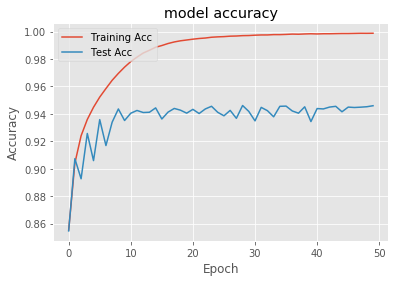

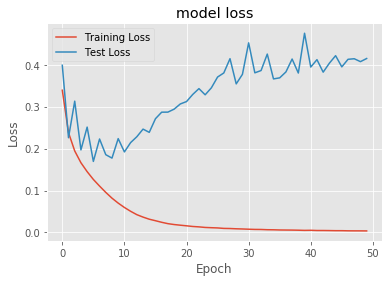

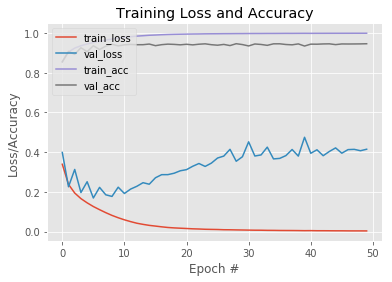

In [15]:
plt.style.use("ggplot")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [16]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

Validation Score:  0.36898998155516893
Validation Accuracy:  0.9525


In [17]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

492/492 [==============================] - 11s 23ms/step
No of errors = 835/15744


Confusion Matrix
[[5950  418]
 [ 417 8959]]


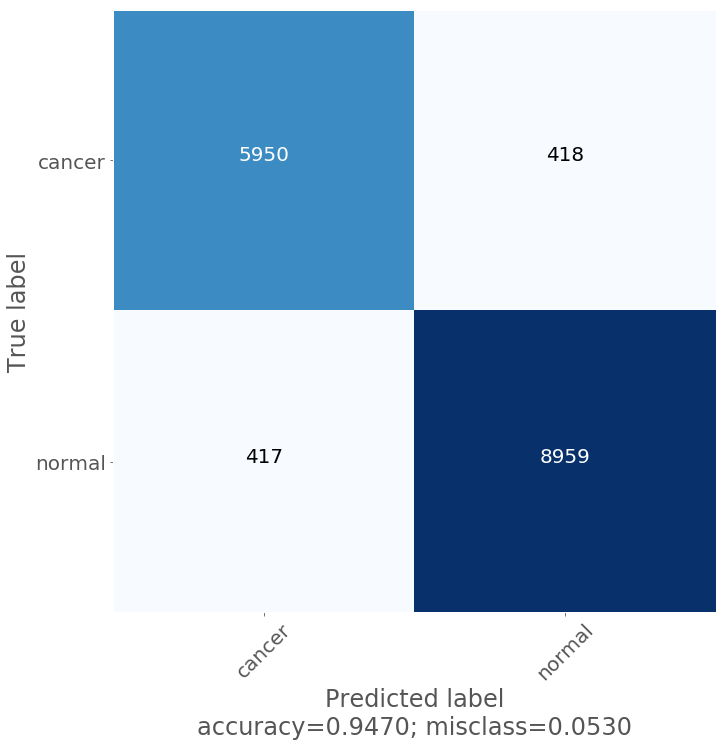

In [18]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
#                           title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('plots/7.ResNet50-Kaggle-Histo-CM.png', bbox_inches='tight', dpi = 100) 
plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels)

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[5950  418]
 [ 417 8959]]
              precision    recall  f1-score   support

      cancer       0.93      0.93      0.93      6368
      normal       0.96      0.96      0.96      9376

   micro avg       0.95      0.95      0.95     15744
   macro avg       0.94      0.94      0.94     15744
weighted avg       0.95      0.95      0.95     15744



In [20]:
total=sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1]) / total
print ('Accuracy : ', accuracy)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity )

Accuracy :  0.9469639227642277
Sensitivity :  0.9345060468038323
Specificity :  0.9554228431267996


In [21]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

th = 0.3

acc = accuracy_score(truth,predict_class > th)
prec = precision_score(truth,predict_class > th)
f1 = f1_score(truth,predict_class > th)
recall = recall_score(truth,predict_class > th)

print('Accuracy:  {:.4f}'.format(acc))
print('Precision: {:.4f}'.format(prec))
print('Recall:    {:.4f}'.format(recall))
print('F1:        {:.4f}'.format(f1))

Accuracy:  0.9470
Precision: 0.9554
Recall:    0.9555
F1:        0.9555


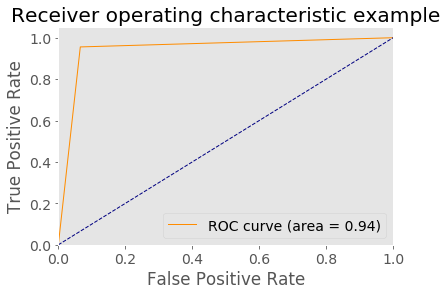

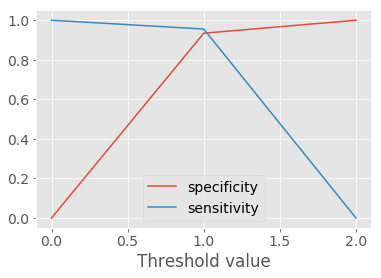

In [22]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 14})

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(test_generator.classes, predict_class)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#plotting sensitivity and specificity
plt.figure()
plt.plot(thresholds, 1-fpr, label = 'specificity')
plt.plot(thresholds, tpr, label = 'sensitivity')
plt.legend()
plt.grid()
plt.xlabel('Threshold value')
plt.show()

In [23]:
model.save('models/10.AlexNet-Kaggle-histo-Model.h5')
model.save_weights('models/10.AlexNet-Kaggle-histo-Weights.h5')